In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_selection import SelectFromModel, RFECV

In [2]:
data_train = pd.read_csv('Data/train_set.csv')
data_test = pd.read_csv('Data/test_set.csv')

/var/folders/sx/53qsrth94qs34_k0n9s4w_mh0000gn/T/ipykernel_53292/4187072533.py:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  data_train = pd.read_csv('Data/train_set.csv')
/var/folders/sx/53qsrth94qs34_k0n9s4w_mh0000gn/T/ipykernel_53292/4187072533.py:2: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  data_test = pd.read_csv('Data/test_set.csv')


### Limpieza y setup de datasets

In [3]:
def cleaning_data(df):

    def parse_dates(date):
        try:
            return pd.to_datetime(date, format='%Y-%m-%d %H:%M:%S')
        except ValueError:
            try:
                return pd.to_datetime(date, format='%m/%d/%Y %H:%M')
            except ValueError:
                return pd.NaT
    
    df['start_time'] = df['start_time'].apply(parse_dates)
    df['end_time'] = df['end_time'].apply(parse_dates)

    geo_columns = ['start_lat', 'start_lon', 'end_lat', 'end_lon']

    for col in geo_columns:
        if 'start' in col:
            df[col] = df.groupby('start_station')[col].transform(lambda x: x.fillna(x.median()))
            df[col] = df.groupby('start_station')[col].transform(lambda x: x.fillna(x.median()))
        else:
            df[col] = df.groupby('end_station')[col].transform(lambda x: x.fillna(x.median()))
            df[col] = df.groupby('end_station')[col].transform(lambda x: x.fillna(x.median()))

    for col in geo_columns:
        df[col].fillna(df[col].median(), inplace=True)
        df[col].fillna(df[col].median(), inplace=True)

    return df

In [4]:
data_train = cleaning_data(data_train)
data_test = cleaning_data(data_test)

/var/folders/sx/53qsrth94qs34_k0n9s4w_mh0000gn/T/ipykernel_53292/2572051603.py:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/var/folders/sx/53qsrth94qs34_k0n9s4w_mh0000gn/T/ipykernel_53292/2572051603.py:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alwa

In [5]:
data_test_cleaned = data_test.copy()
data_train_cleaned = data_train.copy()

In [6]:
data_train_cleaned = data_train_cleaned.dropna(subset=['passholder_type'])

In [7]:
def feature_engineering(df):
    
    df['trip_duration_calculated'] = (df['end_time'] - df['start_time']).dt.total_seconds() / 60
    df['is_weekend'] = df['start_time'].dt.weekday >= 5
    
    def haversine(lat1, lon1, lat2, lon2):
        R = 6371.0  # Radio de la Tierra en kilómetros
        lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
        return R * c
    
    df['distance'] = haversine(
        df['start_lat'], df['start_lon'], df['end_lat'], df['end_lon']
    )

    df['start_hour'] = df['start_time'].dt.hour
    bins = [0, 6, 12, 18, 24]
    labels = ['Madrugada', 'Mañana', 'Tarde', 'Noche']
    df['time_slot'] = pd.cut(df['start_hour'], bins=bins, labels=labels, right=False)

    df['day_of_week'] = df['start_time'].dt.day_name()


    return df

In [8]:
data_train_cleaned = feature_engineering(data_train_cleaned)
data_test_cleaned = feature_engineering(data_test_cleaned)

### Handling outliers

In [9]:
def handle_outliers(df):
     # Filtrar por límites IQR para trip_duration_calculated
    q1_duration = df['trip_duration_calculated'].quantile(0.25)
    q3_duration = df['trip_duration_calculated'].quantile(0.75)
    iqr_duration = q3_duration - q1_duration
    lower_bound_duration = q1_duration - 2 * iqr_duration
    upper_bound_duration = q3_duration + 2 * iqr_duration
    
    # Filtrar por límites IQR para distance
    q1_distance = df['distance'].quantile(0.25)
    q3_distance = df['distance'].quantile(0.75)
    iqr_distance = q3_distance - q1_distance
    lower_bound_distance = q1_distance - 2 * iqr_distance
    upper_bound_distance = q3_distance + 2 * iqr_distance

    # Aplicar filtros
    df = df[
        (df['trip_duration_calculated'] >= lower_bound_duration) & 
        (df['trip_duration_calculated'] <= upper_bound_duration) & 
        (df['distance'] >= lower_bound_distance) & 
        (df['distance'] <= upper_bound_distance)
    ]
    return df

In [10]:
data_train_cleaned = handle_outliers(data_train_cleaned)

In [11]:
data_train_cleaned['passholder_type'].value_counts()

passholder_type
Monthly Pass    378671
Walk-up         164302
Annual Pass      32080
One Day Pass     28568
Flex Pass        11208
Testing             55
Name: count, dtype: int64

## Model creation

### Encoding variables

In [12]:
le = LabelEncoder()
data_train_cleaned['passholder_type_encoded'] = le.fit_transform(data_train_cleaned['passholder_type'])
encoder = OneHotEncoder()
encoded_days_train = encoder.fit_transform(data_train_cleaned[['day_of_week', 'time_slot']]).toarray()
encoded_days_test = encoder.transform(data_test_cleaned[['day_of_week', 'time_slot']]).toarray()
le_trip_route = LabelEncoder()
data_train_cleaned['trip_route_category_encoded'] = le_trip_route.fit_transform(data_train_cleaned['trip_route_category'])
data_test_cleaned['trip_route_category_encoded'] = le_trip_route.transform(data_test_cleaned['trip_route_category'])
encoded_columns = encoder.get_feature_names_out(['day_of_week', 'time_slot'])
data_train_cleaned = pd.concat([data_train_cleaned, pd.DataFrame(encoded_days_train, columns=encoded_columns, index=data_train_cleaned.index)], axis=1)
data_test_cleaned = pd.concat([data_test_cleaned, pd.DataFrame(encoded_days_test, columns=encoded_columns, index=data_test_cleaned.index)], axis=1)

In [13]:
features = ['start_station', 'trip_duration_calculated', 'start_hour', 'distance', 'is_weekend'] + list(encoded_columns)

In [14]:
#features = ['trip_duration_calculated', 'start_hour', 'distance', 'is_weekend'] + list(encoded_columns) + ['trip_route_category_encoded']

In [15]:
X_train = data_train_cleaned[features]
y_train = data_train_cleaned['passholder_type_encoded']
X_test = data_test_cleaned[features]
#y_test = le.transform(data_test_cleaned['passholder_type'])

In [16]:
def balance_data(X, y):
    smote = SMOTE(random_state=42)
    X_smote, y_smote = smote.fit_resample(X, y)
    under_sampler = RandomUnderSampler(random_state=42)
    X_balanced, y_balanced = under_sampler.fit_resample(X_smote, y_smote)
    return X_balanced, y_balanced

In [17]:
def add_features(df):
    # Promedio de duración de viajes por estación de inicio
    df['avg_trip_duration_by_station'] = df.groupby('start_station')['trip_duration_calculated'].transform('mean')
    # Interacciones entre variables
    df['duration_distance_ratio'] = df['trip_duration_calculated'] / (df['distance'] + 1e-5)  # Evitar división por cero
    return df

In [18]:
def select_features_with_model(X, y):
    model_temp = RandomForestClassifier(random_state=42)
    model_temp.fit(X, y)
    selector = SelectFromModel(model_temp, prefit=True, threshold="mean")
    selected_features = X.columns[selector.get_support()]
    X_selected = selector.transform(X)
    return X_selected, selected_features

In [19]:
# def perform_cross_validation(model, X, y):
#     kf = KFold(n_splits=5, shuffle=True, random_state=42)
#     cv_scores = cross_val_score(model, X, y, cv=kf, scoring='accuracy')
#     print(f"Accuracy promedio CV: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")
#     return cv_scores

In [20]:
def grid_search_rf(X, y):
    print("\n[Optimized Search - Random Forest]")
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [10, None],
        'min_samples_split': [5, 10],
        'min_samples_leaf': [1, 2],
        'class_weight': ['balanced']
    }
    grid_search = GridSearchCV(
        RandomForestClassifier(random_state=42),
        param_grid=param_grid,
        cv=2,  # Reducir número de particiones
        scoring='accuracy',
        n_jobs=-1  # Paralelizar
    )
    grid_search.fit(X, y)
    print("\n[Random Forest] Mejores parámetros:", grid_search.best_params_)
    return grid_search.best_estimator_

In [21]:
def grid_search_xgb(X, y):
    print("\n[Optimized Search - XGBoost]")
    param_grid = {
        'n_estimators': [50, 100],
        'max_depth': [6, 10],
        'learning_rate': [0.1],
        'scale_pos_weight': [1, 5]
    }
    grid_search = GridSearchCV(
        XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
        param_grid=param_grid,
        cv=3,  # Reducir validación cruzada
        scoring='accuracy',
        n_jobs=-1  # Usar todos los núcleos
    )
    grid_search.fit(X, y)
    print("\n[XGBoost] Mejores parámetros:", grid_search.best_params_)
    return grid_search.best_estimator_

In [24]:
def train_and_evaluate_models(X_train, y_train, X_val, y_val, X_test):
    # 3.1 Validación cruzada para Random Forest
    X_train_balanced, y_train_balanced = balance_data(X_train, y_train)

    print("\n[Random Forest - Validación Cruzada]")
    rf_model = grid_search_rf(X_train_balanced, y_train_balanced)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rf_cv_scores = cross_val_score(rf_model, X_train, y_train, cv=kf, scoring='accuracy')
    print(f"[Random Forest] Accuracy promedio CV: {np.mean(rf_cv_scores):.4f} ± {np.std(rf_cv_scores):.4f}")

    # Validación interna para Random Forest
    rf_model.fit(X_train_balanced, y_train_balanced)
    y_val_pred_rf = rf_model.predict(X_val)
    print("\n[Evaluación en Validación Interna - Random Forest]")
    print("Accuracy:", accuracy_score(y_val, y_val_pred_rf))
    print("Classification Report:\n", classification_report(y_val, y_val_pred_rf, target_names=le.classes_))

    conf_matrix_rf = confusion_matrix(y_val, y_val_pred_rf)
    disp_rf = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_rf, display_labels=le.classes_)
    disp_rf.plot(cmap='viridis')
    plt.title("Random Forest - Matriz de Confusión")
    plt.show()

    # 3.2 Validación cruzada para XGBoost
    print("\n[XGBoost - Validación Cruzada]")
    xgb_model = grid_search_xgb(X_train_balanced, y_train_balanced)
    xgb_cv_scores = cross_val_score(xgb_model, X_train_balanced, y_train_balanced, cv=kf, scoring='accuracy')
    print(f"[XGBoost] Accuracy promedio CV: {np.mean(xgb_cv_scores):.4f} ± {np.std(xgb_cv_scores):.4f}")

    # Validación interna para XGBoost
    xgb_model.fit(X_train_balanced, y_train_balanced)
    y_val_pred_xgb = xgb_model.predict(X_val)
    print("\n[Evaluación en Validación Interna - XGBoost]")
    print("Accuracy:", accuracy_score(y_val, y_val_pred_xgb))
    print("Classification Report:\n", classification_report(y_val, y_val_pred_xgb, target_names=le.classes_))

    conf_matrix_xgb = confusion_matrix(y_val, y_val_pred_xgb)
    disp_xgb = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_xgb, display_labels=le.classes_)
    disp_xgb.plot(cmap='viridis')
    plt.title("XGBoost - Matriz de Confusión")
    plt.show()

    return rf_model, xgb_model

In [26]:
# 7. Predicciones finales
def predict_on_test_set(model, X_test):
    y_test_pred = model.predict(X_test)
    y_test_pred_labels = le.inverse_transform(y_test_pred)
    return y_test_pred_labels

In [27]:
X_train_internal, X_val, y_train_internal, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

X_train_balanced, y_train_balanced = balance_data(X_train_internal, y_train_internal)

X_train_balanced = add_features(X_train_balanced)
X_val = add_features(X_val)
X_test = add_features(X_test)

/var/folders/sx/53qsrth94qs34_k0n9s4w_mh0000gn/T/ipykernel_53292/1950525988.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['avg_trip_duration_by_station'] = df.groupby('start_station')['trip_duration_calculated'].transform('mean')
/var/folders/sx/53qsrth94qs34_k0n9s4w_mh0000gn/T/ipykernel_53292/1950525988.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['duration_distance_ratio'] = df['trip_duration_calculated'] / (df['distance'] + 1e-5)  # Evitar división por cero



[Random Forest - Validación Cruzada]

[Optimized Search - Random Forest]

[Random Forest] Mejores parámetros: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
[Random Forest] Accuracy promedio CV: 0.8598 ± 0.0006

[Evaluación en Validación Interna - Random Forest]
Accuracy: 0.6684908560137262
Classification Report:
               precision    recall  f1-score   support

 Annual Pass       0.30      0.21      0.24      6416
   Flex Pass       0.12      0.08      0.09      2242
Monthly Pass       0.75      0.81      0.78     75734
One Day Pass       0.28      0.19      0.23      5714
     Testing       0.50      0.09      0.15        11
     Walk-up       0.58      0.55      0.56     32860

    accuracy                           0.67    122977
   macro avg       0.42      0.32      0.34    122977
weighted avg       0.65      0.67      0.66    122977



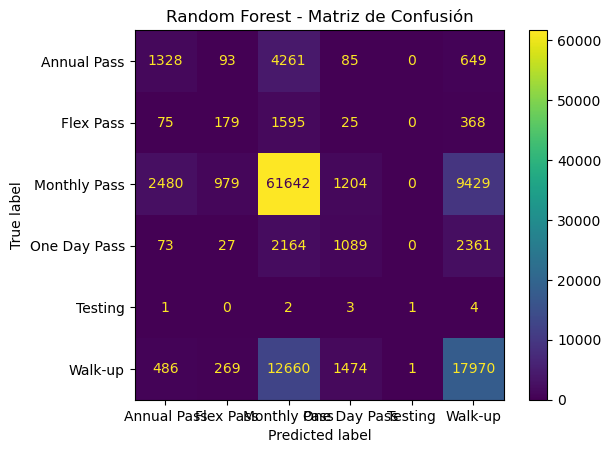


[XGBoost - Validación Cruzada]

[Optimized Search - XGBoost]


/opt/homebrew/anaconda3/envs/test_env/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:38:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/homebrew/anaconda3/envs/test_env/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:38:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/homebrew/anaconda3/envs/test_env/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:38:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/homebrew/anaconda3/envs/test_env/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:38:29] WARNING: /Users/runner/work/xgboost/xgb


[XGBoost] Mejores parámetros: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100, 'scale_pos_weight': 1}


/opt/homebrew/anaconda3/envs/test_env/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:43:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/homebrew/anaconda3/envs/test_env/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:44:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/homebrew/anaconda3/envs/test_env/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:44:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/homebrew/anaconda3/envs/test_env/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:45:00] WARNING: /Users/runner/work/xgboost/xgb

[XGBoost] Accuracy promedio CV: 0.7269 ± 0.0008


/opt/homebrew/anaconda3/envs/test_env/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:45:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



[Evaluación en Validación Interna - XGBoost]
Accuracy: 0.6330452035746522
Classification Report:
               precision    recall  f1-score   support

 Annual Pass       0.23      0.26      0.24      6416
   Flex Pass       0.06      0.11      0.08      2242
Monthly Pass       0.75      0.77      0.76     75734
One Day Pass       0.22      0.23      0.23      5714
     Testing       0.03      0.09      0.04        11
     Walk-up       0.59      0.51      0.54     32860

    accuracy                           0.63    122977
   macro avg       0.31      0.33      0.32    122977
weighted avg       0.64      0.63      0.64    122977



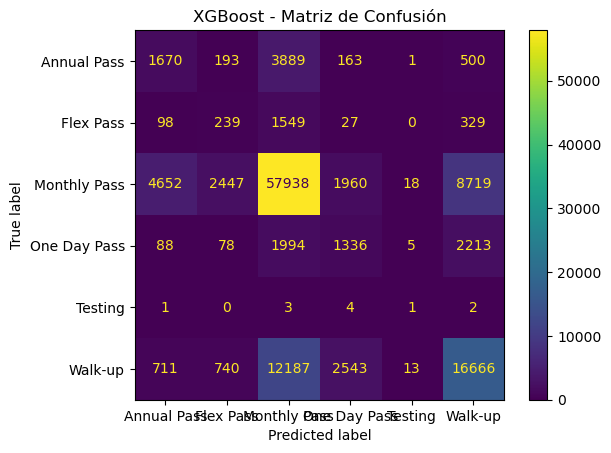

In [28]:
rf_model, xgb_model = train_and_evaluate_models(
    X_train_balanced, y_train_balanced, X_val, y_val, X_test)

In [29]:
y_test_rf = predict_on_test_set(rf_model, X_test)
y_test_xgb = predict_on_test_set(xgb_model, X_test)

In [30]:
predictions_df = pd.DataFrame({
    'trip_id': data_test_cleaned['trip_id'],  # Identificador único
    'predicted_rf': y_test_rf,
    'predicted_xgb': y_test_xgb
})

In [31]:
predictions_df.to_csv("predicciones_finales.csv", index=False)
print(predictions_df.head())

    trip_id predicted_rf predicted_xgb
0  17059130      Walk-up       Walk-up
1  17059129      Walk-up       Walk-up
2  17059126      Walk-up       Walk-up
3  17059125      Walk-up       Walk-up
4  17061379      Walk-up       Walk-up


In [40]:
predictions_df.groupby('predicted_rf')[['trip_id']].count()

,trip_id
predicted_rf,
Annual Pass,6415
Flex Pass,5614
Monthly Pass,254516
One Day Pass,33565
Walk-up,269776


In [41]:
predictions_df.groupby('predicted_xgb')[['trip_id']].count()

,trip_id
predicted_xgb,
Annual Pass,30180
Flex Pass,57055
Monthly Pass,187692
One Day Pass,81590
Testing,108
Walk-up,213261


In [42]:
predictions_df.to_csv("predicciones_rf_vs_xgb.csv", index=False)
print(predictions_df.head())

    trip_id predicted_rf predicted_xgb
0  17059130      Walk-up       Walk-up
1  17059129      Walk-up       Walk-up
2  17059126      Walk-up       Walk-up
3  17059125      Walk-up       Walk-up
4  17061379      Walk-up       Walk-up


In [43]:
def plot_feature_importance(model, feature_names, title):
    importances = model.feature_importances_
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=importance_df, x='Importance', y='Feature')
    plt.title(title)
    plt.show()

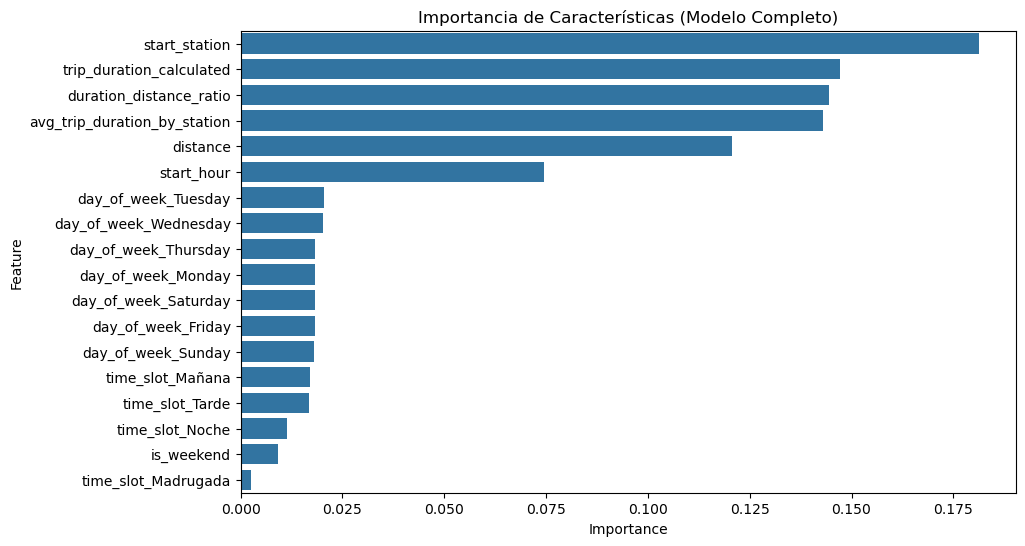

In [45]:
#Feature Importance del modelo completo
plot_feature_importance(rf_model, X_train_balanced.columns, "Importancia de Características (Modelo Completo)")

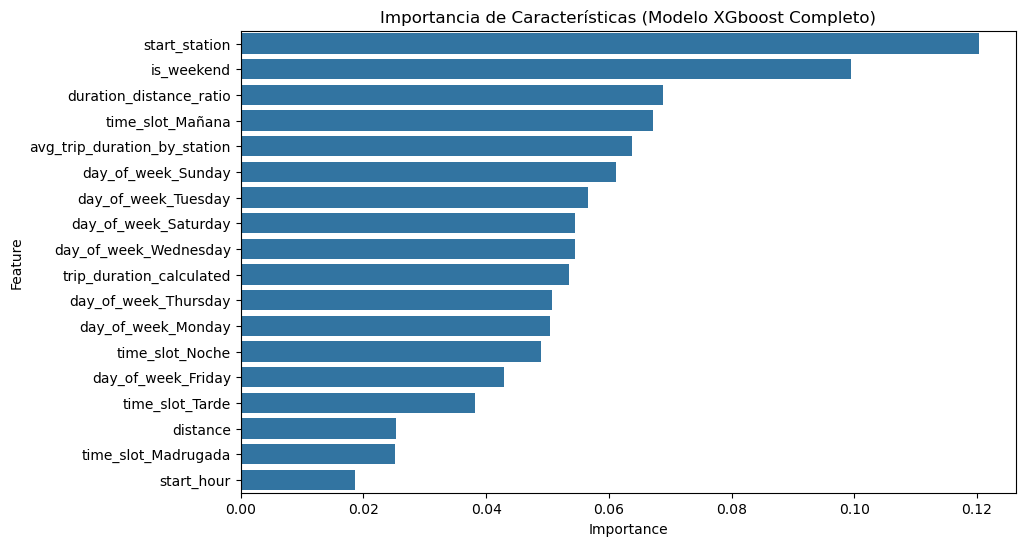

In [46]:
#Plot de feature importance para XGboost
plot_feature_importance(xgb_model, X_train_balanced.columns, "Importancia de Características (Modelo XGboost Completo)")